In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import tensorflow as tf
print(tf.__version__)

2.8.0


In [3]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [5]:
import csv
time_step = []
temps = []

with open('/data/daily-min-temperatures.csv') as csvfile:
    csvreader = csv.reader(csvfile)
    header = next(csvreader)
    for i, row in enumerate(csvreader):
        time_step.append(i)
        temps.append(float(row[1]))
        
    

In [6]:
len(time_step)

3650

# Sunspot activity

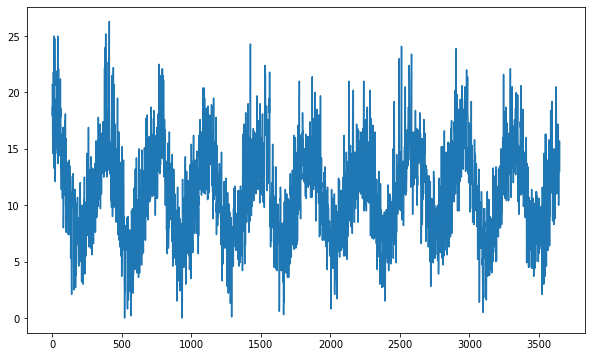

In [7]:

    
. READ TEMPERATURES INTO TEMPS
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
#plot_series(time, series)
plt.plot(time, series)

In [8]:
split_time = 2500
time_train = time[:split_time] 
x_train = series[:split_time] 
time_valid = time[split_time:] 
x_valid = series[split_time:] 

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [9]:
dataset = tf.data.Dataset.from_tensor_slices(series)
for x in dataset:
    print(x)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

tf.Tensor(20.7, shape=(), dtype=float64)
tf.Tensor(17.9, shape=(), dtype=float64)
tf.Tensor(18.8, shape=(), dtype=float64)
tf.Tensor(14.6, shape=(), dtype=float64)
tf.Tensor(15.8, shape=(), dtype=float64)
tf.Tensor(15.8, shape=(), dtype=float64)
tf.Tensor(15.8, shape=(), dtype=float64)
tf.Tensor(17.4, shape=(), dtype=float64)
tf.Tensor(21.8, shape=(), dtype=float64)
tf.Tensor(20.0, shape=(), dtype=float64)
tf.Tensor(16.2, shape=(), dtype=float64)
tf.Tensor(13.3, shape=(), dtype=float64)
tf.Tensor(16.7, shape=(), dtype=float64)
tf.Tensor(21.5, shape=(), dtype=float64)
tf.Tensor(25.0, shape=(), dtype=float64)
tf.Tensor(20.7, shape=(), dtype=float64)
tf.Tensor(20.6, shape=(), dtype=float64)
tf.Tensor(24.8, shape=(), dtype=float64)
tf.Tensor(17.7, shape=(), dtype=float64)
tf.Tensor(15.5, shape=(), dtype=float64)
tf.Tensor(18.2, shape=(), dtype=float64)
tf.Tensor(12.1, shape=(), dtype=float64)
tf.Tensor(14.4, s

2022-04-20 19:21:22.449899: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-20 19:21:22.450024: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [25]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # Create a
    
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
    

In [26]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size ))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast
    

In [27]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)


<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>
(2500,)


In [28]:


model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 32)          192       
                                                                 
 lstm (LSTM)                 (None, None, 64)          24832     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          33024     
                                                                 
 dense (Dense)               (None, None, 30)          1950      
                                                                 
 dense_1 (Dense)             (None, None, 10)          310       
                                                                 
 dense_2 (Dense)             (None, None, 1)           11        
                                                                 
 lambda (Lambda)             (None, None, 1)           0

# Searching for the appropriate learning rate

In [29]:

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 10))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=50, verbose=2, callbacks=[lr_schedule])


Epoch 1/50


2022-04-20 19:26:16.159467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-20 19:26:16.432973: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-20 19:26:16.522781: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-20 19:26:16.756346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-20 19:26:16.898887: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 - 3s - loss: 59.3274 - mae: 59.8274 - lr: 1.0000e-08 - 3s/epoch - 283ms/step
Epoch 2/50
10/10 - 0s - loss: 55.8203 - mae: 56.3202 - lr: 1.2589e-08 - 428ms/epoch - 43ms/step
Epoch 3/50
10/10 - 0s - loss: 50.0227 - mae: 50.5226 - lr: 1.5849e-08 - 427ms/epoch - 43ms/step
Epoch 4/50
10/10 - 0s - loss: 42.2529 - mae: 42.7526 - lr: 1.9953e-08 - 422ms/epoch - 42ms/step
Epoch 5/50
10/10 - 0s - loss: 32.3531 - mae: 32.8526 - lr: 2.5119e-08 - 430ms/epoch - 43ms/step
Epoch 6/50
10/10 - 0s - loss: 20.0760 - mae: 20.5737 - lr: 3.1623e-08 - 423ms/epoch - 42ms/step
Epoch 7/50
10/10 - 0s - loss: 9.5128 - mae: 10.0005 - lr: 3.9811e-08 - 417ms/epoch - 42ms/step
Epoch 8/50
10/10 - 0s - loss: 8.1236 - mae: 8.6121 - lr: 5.0119e-08 - 417ms/epoch - 42ms/step
Epoch 9/50
10/10 - 0s - loss: 7.8204 - mae: 8.3090 - lr: 6.3096e-08 - 424ms/epoch - 42ms/step
Epoch 10/50
10/10 - 0s - loss: 7.0463 - mae: 7.5319 - lr: 7.9433e-08 - 424ms/epoch - 42ms/step
Epoch 11/50
10/10 - 0s - loss: 6.5470 - mae: 7.0298 - lr: 1

(1e-08, 0.001, 0.0, 15.0)

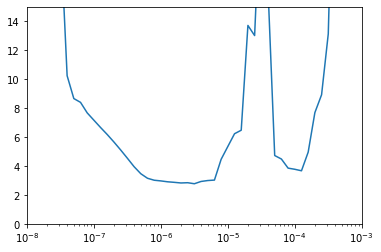

In [23]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 15])

In [30]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)



model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=128, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=2E-6, momentum=0.9), momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=100))
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/100


2022-04-20 19:33:40.341504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-20 19:33:40.631510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-20 19:33:40.792665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-20 19:33:40.964228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-20 19:33:41.109641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - 3s 49ms/step - loss: 6.6014 - mae: 7.0827
Epoch 2/100
25/25 [==============================] - 1s 38ms/step - loss: 2.5206 - mae: 2.9827
Epoch 3/100
25/25 [==============================] - 1s 34ms/step - loss: 2.2278 - mae: 2.6856
Epoch 4/100
25/25 [==============================] - 1s 40ms/step - loss: 2.0944 - mae: 2.5503
Epoch 5/100
25/25 [==============================] - 1s 35ms/step - loss: 2.0344 - mae: 2.4892
Epoch 6/100
25/25 [==============================] - 1s 35ms/step - loss: 1.9887 - mae: 2.4431
Epoch 7/100
25/25 [==============================] - 1s 34ms/step - loss: 1.9669 - mae: 2.4206
Epoch 8/100
25/25 [==============================] - 1s 34ms/step - loss: 1.9314 - mae: 2.3847
Epoch 9/100
25/25 [==============================] - 1s 35ms/step - loss: 1.9094 - mae: 2.3620
Epoch 10/100
25/25 [==============================] - 1s 33ms/step - loss: 1.8716 - mae: 2.3238
Epoch 11/100
25/25 [==============================] - 1s 33ms

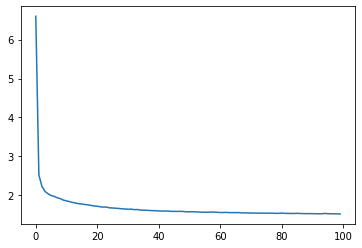

In [31]:
plt.plot(history.history["loss"])

In [32]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

2022-04-20 19:35:17.738244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-20 19:35:17.826269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-20 19:35:17.905766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


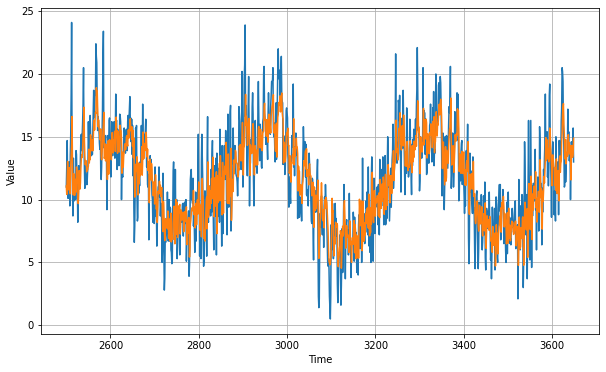

In [33]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [34]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2

1.8147385

In [35]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[11.080352 10.412459 11.702163 ... 13.369815 13.56492  14.883049]
